In [4]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import platform
print (sklearn.__version__) # has to be 0.21.2 for hscScore to work
data_dir = './'

0.21.2


In [5]:
hsc_score = pickle.load(open(data_dir + 'hscScore_model.pkl', 'rb'))


In [6]:
import scvelo as scv


In [7]:
file = "mouseBM_with_velo.loom"
adata_loom = scv.read_loom(file)
adata_loom
file = "mouseBM.h5ad"
adata = scv.read(file)
adata
adata_loom.obsm['X_wnn.umap'] = adata.obsm['X_wnn.umap']
s = scv.read("spliced.csv")
u = scv.read("unspliced.csv")
adata_loom.layers['spliced'] = s.X
adata_loom.layers['unspliced'] = u.X
adata_loom.obs['seurat_clusters'] = adata_loom.obs['seurat_clusters'].apply(lambda x:str(int(x)-1))


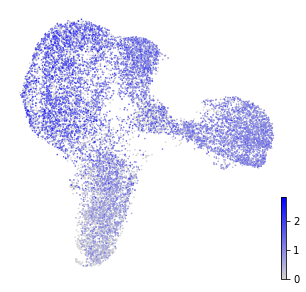

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
from matplotlib.colors import ListedColormap
cmap_blue = clr.LinearSegmentedColormap.from_list('custom blue', ['lightgrey','blue'], N=255)
colors = ['#F8766D','#E7851E','#D09400','#B2A100','#89AC00','#45B500','#00BC51','#00C087','#00C0B2','#00BCD6','#00B3F2','#29A3FF','#9C8DFF','#D277FF','#F166E8','#FF61C7','#FF689E']
cdict = {str(i):colors[i] for i in range(len(colors)) }
# scv.pl.velocity_embedding_stream(adata_no_murk, basis="X_wnn.umap", color="seurat_clusters",figsize=(10,10),palette=cdict)

scv.pl.scatter(adata_loom, color='Nfix',basis="X_wnn.umap",color_map=cmap_blue,size=10, colorbar=True,title = '',figsize=(5,5),palette=cdict)

In [32]:
hsc_genes = pd.read_csv("model_molo_genes.txt",header=None)[0].tolist()

In [40]:
len(set(adata_loom.var_names.tolist()).intersection(hsc_genes))

99

In [55]:
norm_count = adata_loom.to_df(layer="counts")
for g in hsc_genes:
    if not g in norm_count:
        norm_count[g]=0
norm_count = norm_count[hsc_genes]

In [54]:
def total_count_normalise(count_matrix):
    """Normalise count matrix for input into hscScore model.
    Performs read depth normalisation normalising each cell so that normalised 
    counts sum to the same value.
    
    Parameters
    ----------
    count_matrix : pandas dataframe
        Gene count matrix of dimension cells x genes with column names as genes
        and index as cell names
    
    Returns
    -------
    **norm_matrix** : pandas dataframe
        Normalised count matrix of dimension cells x genes
    """
    
    # Set the value normalised counts will sum to for each cell
    wilson_molo_genes_median_counts = 18704.5
    
    # Scale rows
    count_matrix_expression = np.array(count_matrix, dtype='float')
    counts_per_cell = np.sum(count_matrix_expression, axis=1)
    counts_per_cell += (counts_per_cell == 0)
    counts_per_cell /= wilson_molo_genes_median_counts
    norm_matrix_expression =  count_matrix_expression/counts_per_cell[:, None]
    norm_matrix = pd.DataFrame(norm_matrix_expression, index=count_matrix.index,
                               columns=count_matrix.columns)
    # log + 1 transform the data
    norm_matrix = np.log(norm_matrix + 1)
    
    return norm_matrix

In [56]:
norm_count = total_count_normalise(norm_count)


In [57]:
norm_count

Gene,2810417H13Rik,Aqp1,Aqp9,Arhgap27,Arhgap5,Asf1b,Aspm,Birc5,Cacybp,Ccna2,...,Top2a,Tor1b,Trim47,Trip13,Ube2c,Ubl3,Uhrf1,Vps18,Vwf,Yme1l1
CellID,,,,,,,,,,,,,,,,,,,,,
mWT_AAACCCAAGTGATCGG-1,0.0,0.000000,0.000000,6.94711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,6.947110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
mWT_AAACCCACAAACCATC-1,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,5.434175,6.125137,0.000000,...,6.125137,0.000000,0.000000,0.000000,0.000000,5.434175,5.434175,0.000000,0.00000,0.000000
mWT_AAACCCACACTGTCCT-1,0.0,6.329748,0.000000,0.00000,4.727414,4.727414,0.000000,6.107050,6.107050,6.329748,...,5.820110,0.000000,0.000000,0.000000,5.416127,0.000000,5.416127,0.000000,0.00000,4.727414
mWT_AAACCCACAGCCATTA-1,0.0,5.277291,0.000000,0.00000,0.000000,5.277291,5.277291,5.277291,6.372493,5.277291,...,6.659748,5.277291,5.277291,5.277291,0.000000,0.000000,0.000000,5.967881,0.00000,0.000000
mWT_AAACCCAGTACCTAAC-1,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,5.757916,6.449483,5.757916,5.757916,...,7.259535,5.067922,4.381050,0.000000,7.259535,5.471286,0.000000,0.000000,4.38105,5.471286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mNFIXko_TTTGTTGCAAGTGGGT-1,0.0,0.000000,0.000000,0.00000,0.000000,5.591760,0.000000,5.878509,6.793119,5.188157,...,7.198210,0.000000,0.000000,4.500577,6.436925,4.500577,4.500577,0.000000,0.00000,5.188157
mNFIXko_TTTGTTGCACGCTATA-1,0.0,0.000000,0.000000,0.00000,6.101093,0.000000,0.000000,0.000000,6.101093,0.000000,...,0.000000,6.101093,0.000000,0.000000,0.000000,6.793119,0.000000,0.000000,0.00000,0.000000
mNFIXko_TTTGTTGCAGTAACCT-1,0.0,5.523033,5.523033,0.00000,5.523033,5.523033,0.000000,0.000000,6.906328,0.000000,...,6.214181,0.000000,0.000000,0.000000,0.000000,0.000000,6.618979,0.000000,0.00000,0.000000


In [58]:
predicted_hsc_scores = hsc_score.predict(norm_count)


In [61]:
adata_loom.obs['hscScore'] = predicted_hsc_scores

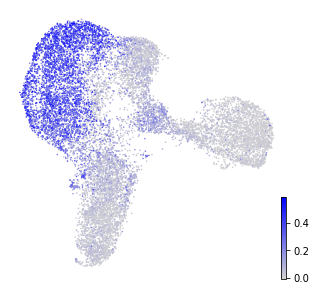

In [62]:
scv.pl.scatter(adata_loom, color='hscScore',basis="X_wnn.umap",color_map=cmap_blue,size=10, colorbar=True,title = '',figsize=(5,5),palette=cdict)

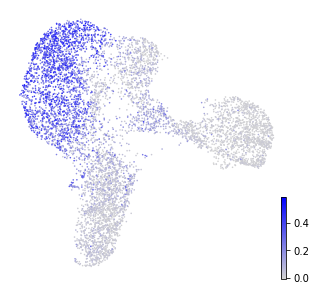

In [63]:
mWT = adata_loom[adata_loom.obs['orig.ident']=="mWT",:]
mNFIXko = adata_loom[adata_loom.obs['orig.ident']=="mNFIXko",:]
scv.pl.scatter(mWT, color='hscScore',basis="X_wnn.umap",color_map=cmap_blue,size=10, colorbar=True,title = '',figsize=(5,5),palette=cdict)

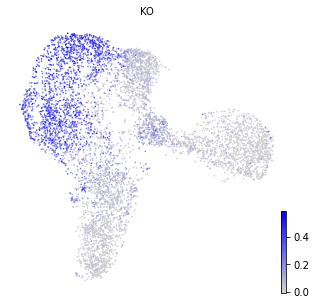

In [65]:
scv.pl.scatter(mNFIXko, color='hscScore',basis="X_wnn.umap",color_map=cmap_blue,size=10, colorbar=True,title = 'KO',figsize=(5,5),palette=cdict)